# *Importing Libraries*

In [2]:
import os
import cv2
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization, Flatten, MaxPooling2D, Dropout

from scipy.stats import ttest_rel

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, matthews_corrcoef

# *Preprocessing*

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset+/data_path.csv")
df.head()

In [ ]:
df.shape

In [ ]:
def read_images_from_df(df):
    images = []
    labels = []
    count = 1
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)
        count += 1
    return images, labels

images, labels = read_images_from_df(df)

### Show sample

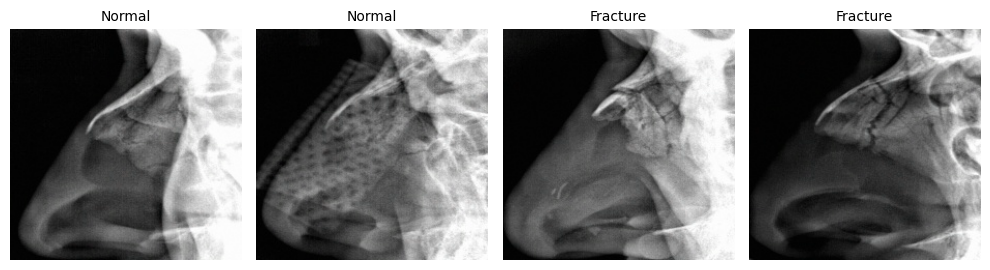

In [7]:
def show_smp(images, labels):
    fig, axes = plt.subplots(1, 4, figsize=(10, 8))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    for i in range(4):
        idx = 2 * i + 1474
        ax = axes[i]
        ax.imshow(images[idx])
        if labels[idx] == 0:
            label = 'Normal'
        else:
            label = 'Fracture'
        ax.set_title(label, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


show_smp(images, labels)

## *Split data on train val test*

In [8]:
X_train, X_val_test, y_train, y_val_test = train_test_split(np.asarray(images), np.asarray(labels), test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
print("shape of X_train is: {} ".format(X_train.shape))
print("shape of X_val is: {}".format(X_val.shape))
print("shape of X_test is: {}".format(X_test.shape))
print()
print("shape of y_train is: {} ".format(y_train.shape))
print("shape of y_val is: {}".format(y_val.shape))
print("shape of y_test is: {}".format(y_test.shape))

## *Data Augmentation*

In [10]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(
    np.array(X_train),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)

validation_generator = validation_datagen.flow(
    np.array(X_val),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

test_generator = test_datagen.flow(
    np.array(X_test),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
classes = np.unique(labels)
classes

In [ ]:
img, lable = train_generator.__next__()
img.shape

### Show sample:

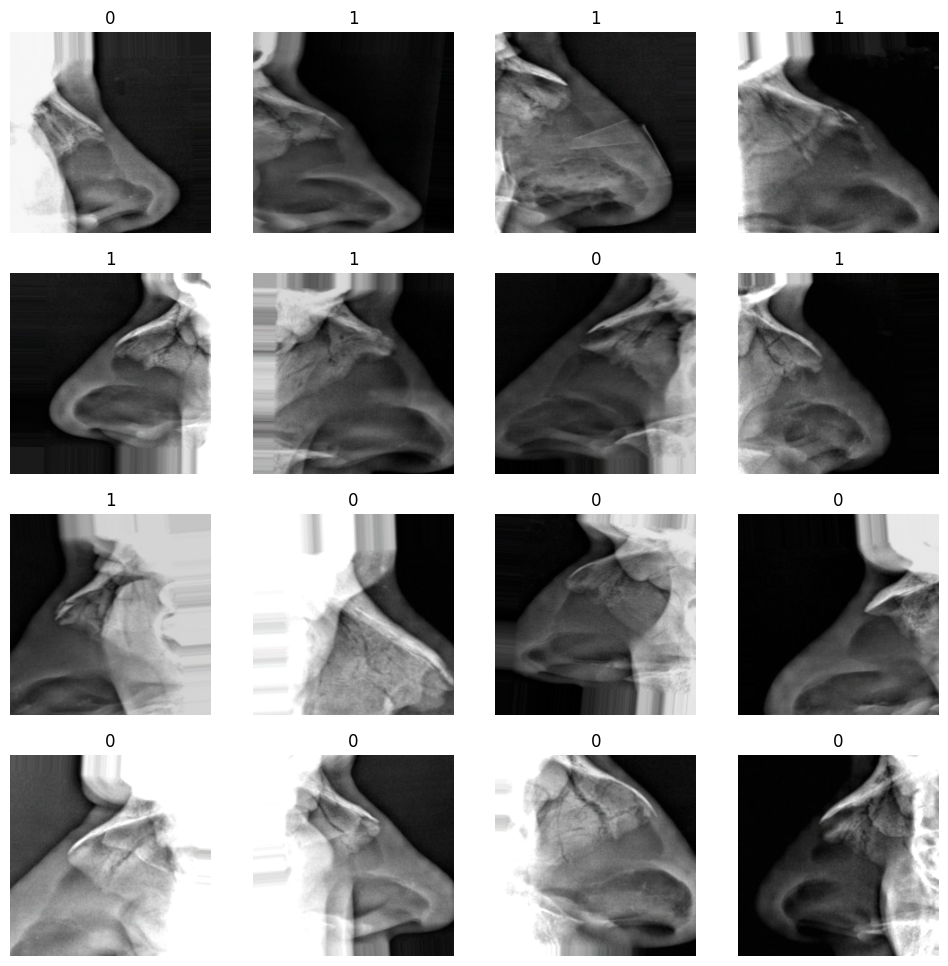

In [ ]:
def show_sample(img, lable):
    plt.figure(figsize= (12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.title(lable[i])
        plt.axis('off')
    plt.show()

show_sample(img, lable)

In [ ]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='navy')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='navy')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()

    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss)))

In [ ]:
def roc_auc_score_(y_test, y_pred):
    auc_ = roc_auc_score(y_test, y_pred)
    print("AUC:", auc_)
    print()

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='khaki', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def confusion_matrix_(y_test, y_pred, name):
    cm = confusion_matrix(y_test, y_pred)
    cmap = sns.color_palette(["#FFFFFF", "#00004D"])

    class_labels = ['normal', 'fracture']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, linewidths=1.5,
                linecolor='black', xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted label", fontsize = 12, fontweight = 'bold')
    plt.ylabel("True label", fontsize = 12, fontweight = 'bold')
    plt.title(name, fontsize = 15, fontweight = 'bold')
    plt.show()

In [ ]:
def metrics(y_test, y_pred):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f0_5_score = fbeta_score(y_test, y_pred, beta=0.5, average='weighted')
    f1_score = fbeta_score(y_test, y_pred, beta=1, average='weighted')
    f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    mcc_score = matthews_corrcoef(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    output = (
        f"{'Metric':<15}{'Score':>10}\n"
        f"{'-'*25}\n"

        f"{'Sensitivity':<15}{sensitivity:>10.6f}\n"
        f"{'Specificity':<15}{specificity:>10.6f}\n"
        f"{'F0.5 Score':<15}{f0_5_score:>10.6f}\n"
        f"{'MCC Score':<15}{mcc_score:>10.6f}\n"

        f"{'.'*25}\n"

        f"{'Precision':<15}{precision:>10.6f}\n"
        f"{'Recall':<15}{recall:>10.6f}\n"
        f"{'F1 Score':<15}{f1_score:>10.6f}\n"
        f"{'F2 Score':<15}{f2_score:>10.6f}\n"
    )
    print(output)

In [ ]:
def lr_schedule(epoch):
    initial_learning_rate = LR
    decay = 0.92
    lr = initial_learning_rate * decay**(1.25 * epoch)
    if lr > 1e-4:
        return lr
    else:
        return 1e-4

lr_scheduler = LearningRateScheduler(lr_schedule)

---
## *Model*

In [12]:
from keras.models import load_model

expert1 = load_model('/content/drive/MyDrive/Models/Xception_N19.keras')
expert2 = load_model('/content/drive/MyDrive/Models/DenseNet121_F24.keras')
expert3 = load_model('/content/drive/MyDrive/Models/InceptionResNetV2_F25_N32.keras')


In [ ]:
expert1.trainable = False
expert2.trainable = False
expert3.trainable = False

In [ ]:
expert1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18432)          │        73,728 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,749,920 (334.74 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 30,408,170 (116.00 MB)

 Optimizer params: 57,341,750 (218.74 MB)

In [ ]:
layers_to_remove = ['dense_2']

layers_to_keep = [layer for layer in expert1.layers if layer.name not in layers_to_remove]

expert1_base = Sequential()

for layer in layers_to_keep:
    expert1_base.add(layer)

In [ ]:
expert1_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18432)          │        73,728 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,408,040 (116.00 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 30,408,040 (116.00 MB)

In [ ]:
expert2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9216)           │        36,864 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,243,016 (111.55 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,828,738 (45.12 MB)

 Optimizer params: 17,414,278 (66.43 MB)

In [ ]:
layers_to_remove = ['dense_2']

layers_to_keep = [layer for layer in expert2.layers if layer.name not in layers_to_remove]

expert2_base = Sequential()

for layer in layers_to_keep:
    expert2_base.add(layer)

In [ ]:
expert2_base.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9216)           │        36,864 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,828,608 (45.12 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,828,608 (45.12 MB)

In [ ]:
expert3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 1536)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 6144)           │        24,576 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,146,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_204         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_205         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,279,912 (645.75 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 57,542,818 (219.51 MB)

 Optimizer params: 111,737,094 (426.24 MB)

In [ ]:
layers_to_remove = ['dense_2']

layers_to_keep = [layer for layer in expert3.layers if layer.name not in layers_to_remove]

expert3_base = Sequential()

for layer in layers_to_keep:
    expert3_base.add(layer)

In [ ]:
expert3_base.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 1536)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 6144)           │        24,576 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,146,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_204         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_205         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,542,688 (219.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 57,542,688 (219.51 MB)

---
## Genetic Algorithm

In [ ]:
!pip install pygad

In [ ]:
from tensorflow.keras.utils import to_categorical

X_val_aug = []
y_val_aug = []
for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    X_val_aug.append(x_batch)
    y_val_aug.append(y_batch)
X_val_aug = np.concatenate(X_val_aug)
y_val_aug = np.concatenate(y_val_aug)
y_val_cat = to_categorical(y_val_aug, num_classes=len(classes))

In [ ]:
features1 = expert1_base.predict(X_val_aug)
features2 = expert2_base.predict(X_val_aug)
features3 = expert3_base.predict(X_val_aug)

In [ ]:
def build_classifier_head(input_tensor, num_classes):
    x = Dense(512, activation='relu')(input_tensor)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    return Dense(num_classes, activation='softmax')(x)


In [ ]:
from tensorflow.keras.models import Model

combined_initial = (features1 + features2 + features3) / 3

input_layer = Input(shape=(combined_initial.shape[1],))
output_layer = build_classifier_head(input_layer, y_val_cat.shape[1])
clf = Model(inputs=input_layer, outputs=output_layer)

clf.compile(optimizer=Adamax(5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
clf.fit(combined_initial, y_val_cat, epochs=5, batch_size=16)

In [ ]:
from sklearn.metrics import accuracy_score

clf.trainable = False

def fitness_func(ga_instance, solution, solution_idx):
    w1, w2, w3 = solution
    total = w1 + w2 + w3
    w1 /= total
    w2 /= total
    w3 /= total

    combined = w1 * features1 + w2 * features2 + w3 * features3
    preds = clf.predict(combined, verbose=0)
    acc = accuracy_score(np.argmax(y_val_cat, axis=1), np.argmax(preds, axis=1))
    return acc

In [ ]:
best_weights_per_gen = []

def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(f"Best Fitness so far: {ga_instance.best_solution()[1]:.4f}")
    print(f"Current Best Weights: {ga_instance.best_solution()[0]}")
    print("-" * 50)
    best_solution, _, _ = ga_instance.best_solution()
    best_weights_per_gen.append(best_solution.copy())


In [ ]:
import pygad

ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    sol_per_pop=20,
    num_genes=3,
    fitness_func=fitness_func,
    init_range_low=0,
    init_range_high=1,
    mutation_percent_genes=50,
    mutation_type="random",
    crossover_type="uniform",
    gene_type=float,
    keep_parents=2,
    on_generation=on_generation,
    stop_criteria=["reach_0.98"]
)


In [ ]:
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best Weights: {solution}")
print(f"Best Accuracy: {solution_fitness:.4f}")

Best Weights: [2.93671912 4.66129383 2.12672985]
Best Accuracy: 0.9528


In [ ]:
plt.plot(ga_instance.best_solutions_fitness, color='navy', lw=2)
plt.title("Best Fitness over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.grid(True)
plt.show()

In [ ]:
weights_array = np.array(best_weights_per_gen)
w1 = weights_array[:, 0]
w2 = weights_array[:, 1]
w3 = weights_array[:, 2]

total = w1 + w2 + w3
w1 /= total
w2 /= total
w3 /= total

plt.figure(figsize=(6, 5))
plt.plot(w1, label="w₁ (Xception)", color='grey')
plt.plot(w2, label="w₂ (DenseNet121)", color='orangered')
plt.plot(w3, label="w₃ (InceptionResNetV2)", color='darkblue')
plt.xlabel("Generation")
plt.ylabel("Normalized Weight")
plt.title("Weight Convergence during GA Optimization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
EPOCHS = 50
IMG_SHAPE = (224, 224, 3)
LR = 5e-4
OPTIMIZER = Adamax(LR)
LOSS = SparseCategoricalCrossentropy()
METRICS = ['accuracy']

In [ ]:
from tensorflow.keras.layers import Lambda

best_solution, best_fitness, _ = ga_instance.best_solution()
w1, w2, w3 = best_solution
w1, w2, w3 = w1 / (w1 + w2 + w3), w2 / (w1 + w2 + w3), w3 / (w1 + w2 + w3)

def build_final_model(input_shape):
    input_img = Input(shape=input_shape)

    out1 = expert1_base(input_img)
    out2 = expert2_base(input_img)
    out3 = expert3_base(input_img)

    merged = concatenate([
        Lambda(lambda x: w1 * x)(out1),
        Lambda(lambda x: w2 * x)(out2),
        Lambda(lambda x: w3 * x)(out3)
    ])

    x = Dense(512, activation='relu')(merged)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    output = Dense(len(classes), activation='softmax')(x)

    model = tf.keras.Model(inputs=input_img, outputs=output)
    return model

ga_model = build_final_model(IMG_SHAPE)
ga_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

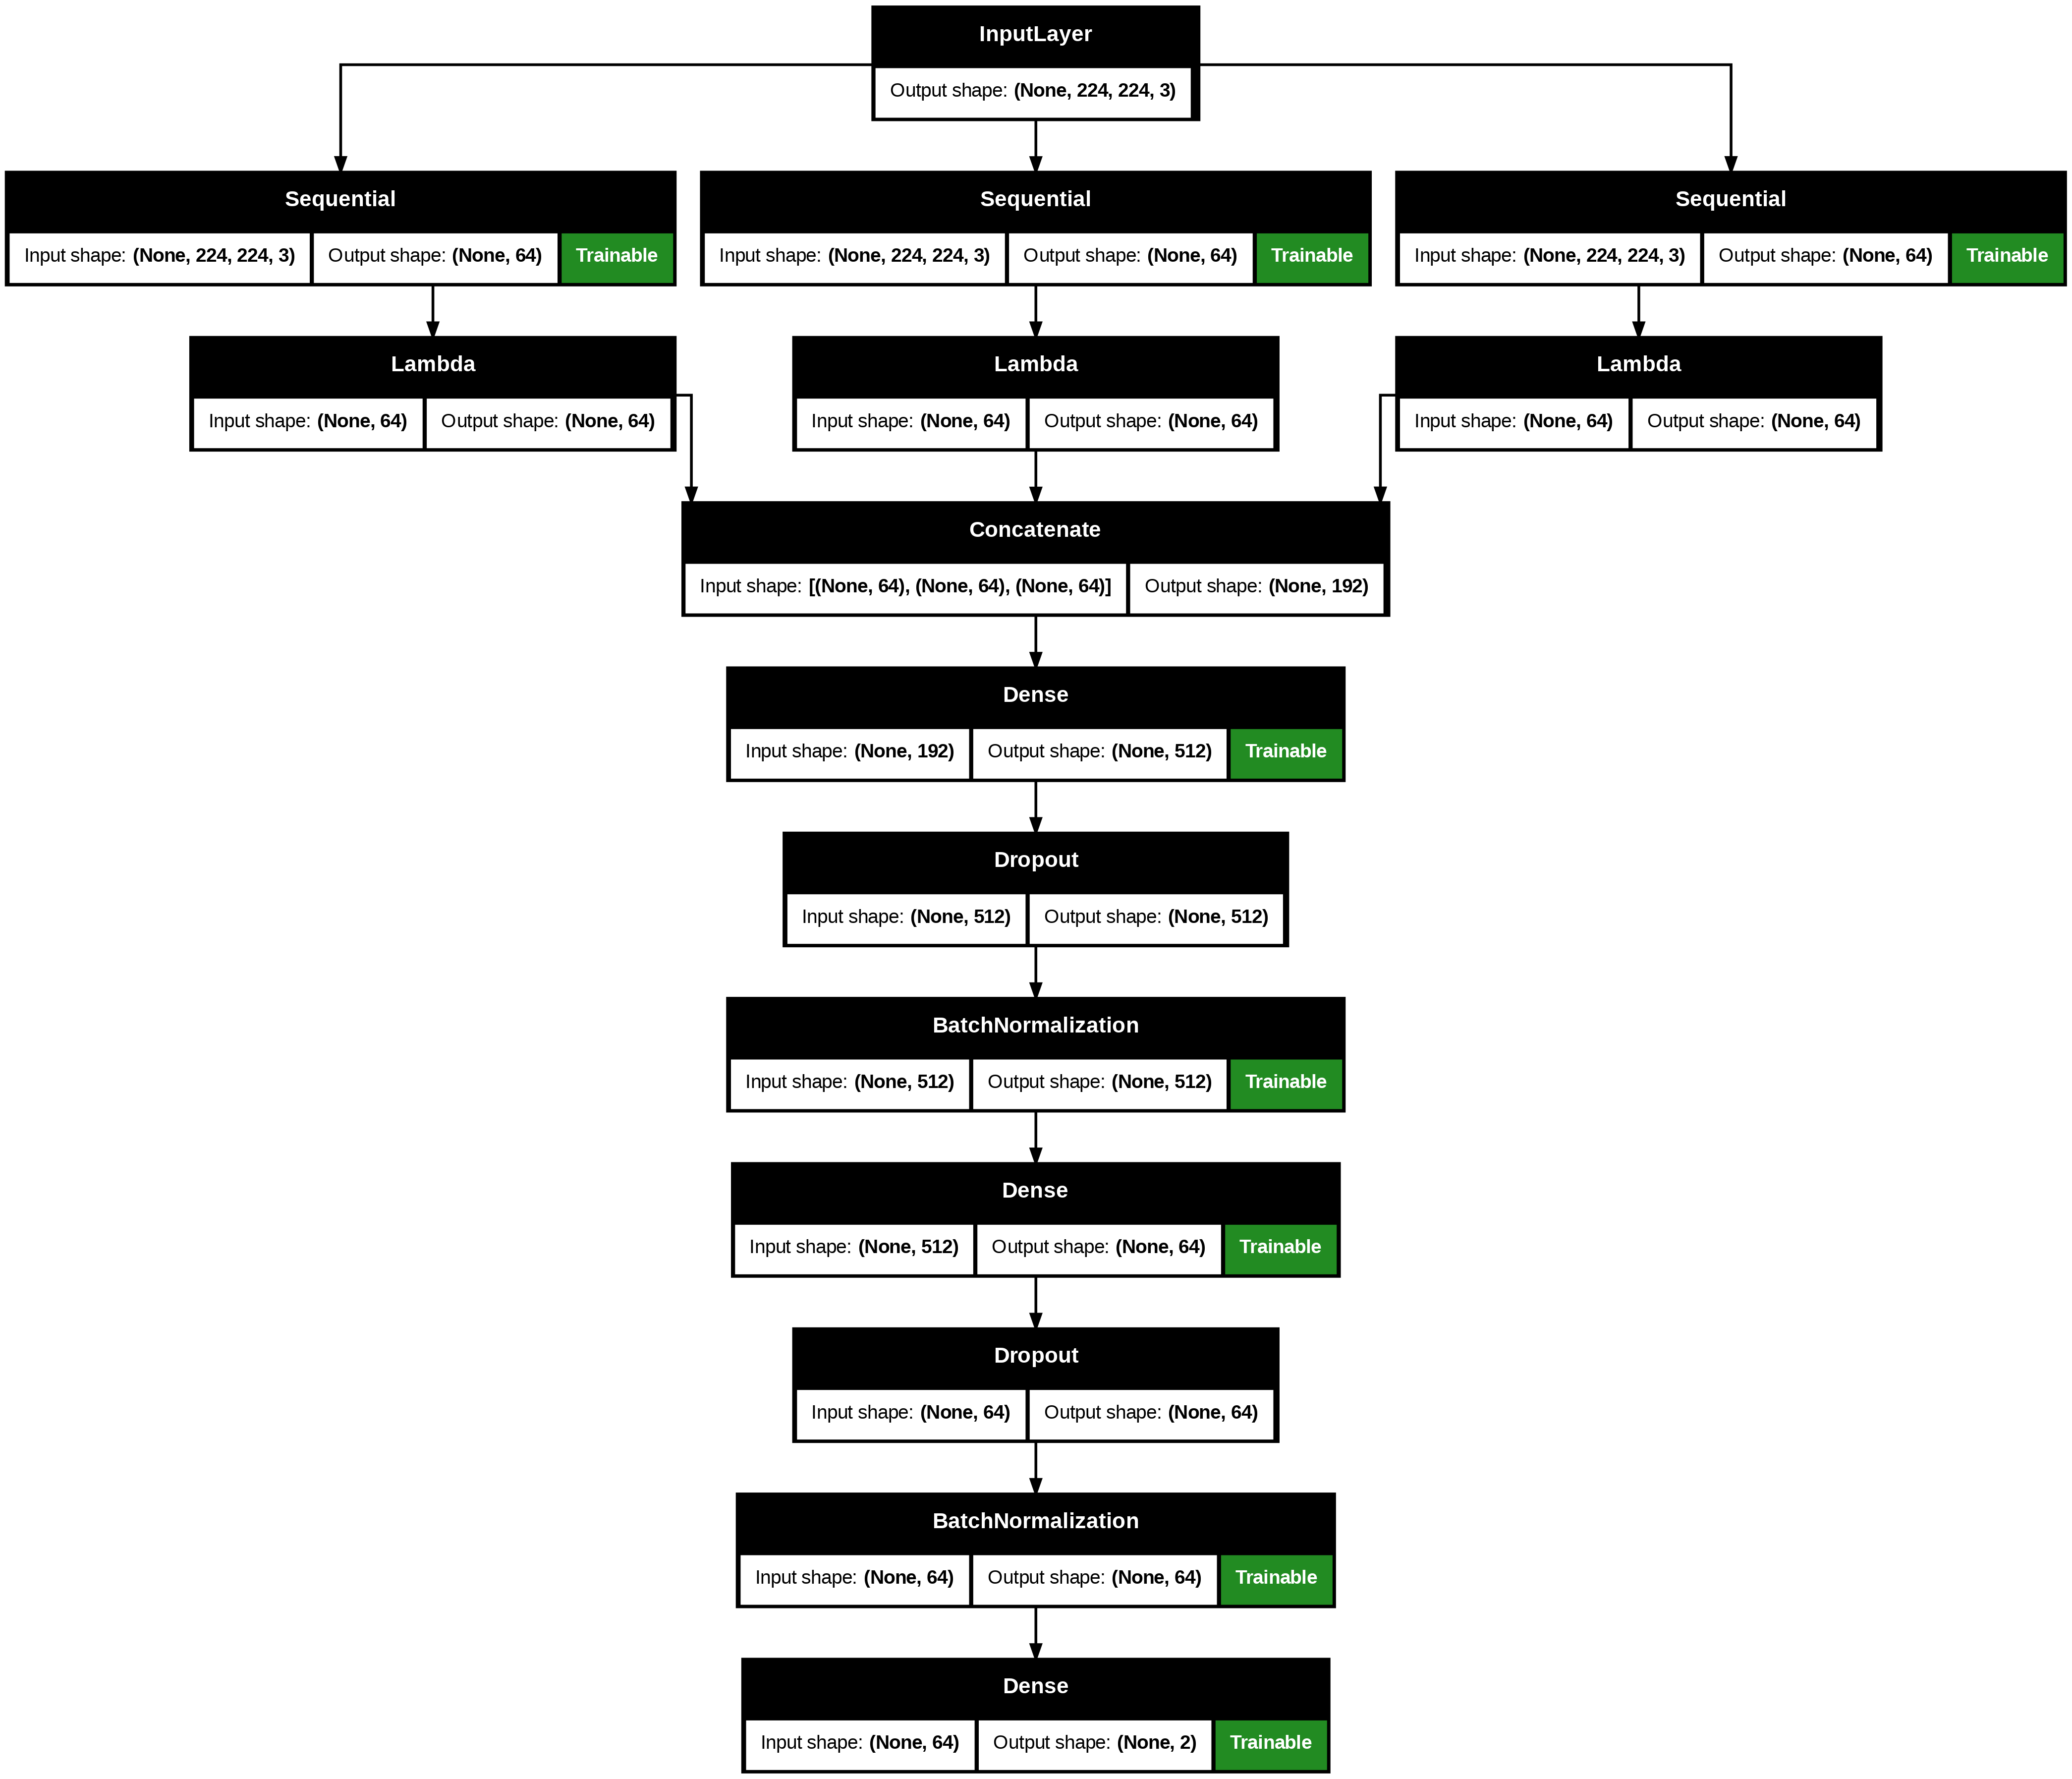

In [ ]:
plot_model(ga_model, show_shapes = True, show_trainable = True)

In [ ]:
ga_hist = ga_model.fit(train_generator, validation_data = validation_generator, epochs = 10, callbacks=[lr_scheduler])

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 179s 883ms/step - accuracy: 0.8389 - loss: 1.4584 - val_accuracy: 0.8944 - val_loss: 1.2959 - learning_rate: 5.0000e-04
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 319ms/step - accuracy: 0.9672 - loss: 1.0719 - val_accuracy: 0.8989 - val_loss: 1.1934 - learning_rate: 4.5051e-04
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - accuracy: 0.9808 - loss: 0.9722 - val_accuracy: 0.9056 - val_loss: 1.1557 - learning_rate: 4.0592e-04
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step - accuracy: 0.9860 - loss: 0.8971 - val_accuracy: 0.9011 - val_loss: 1.1357 - learning_rate: 3.6574e-04
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 319ms/step - accuracy: 0.9872 - loss: 0.8398 - val_accuracy: 0.8944 - val_loss: 1.1092 - learning_rate: 3.2954e-04
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - accuracy: 0.9829 - loss: 0.8055 - val_accuracy: 0.8921 - val_loss: 1.0867 - learning_rate: 2.9692e-04
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 82s 3

In [ ]:
draw_plot(ga_hist)

In [ ]:
loss, acc = ga_model.evaluate(test_generator)
print(f"Test Accuracy using GA weights: ", acc * 100)

In [ ]:
predictions = ga_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step


In [ ]:
metrics(y_test, y_pred)

Metric              Score
-------------------------
Sensitivity      0.919283
Specificity      0.895197
F0.5 Score       0.919922
MCC Score        0.839897
.........................
Precision        0.920614
Recall           0.919283
F1 Score         0.919283
F2 Score         0.919123



In [ ]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.94      0.90      0.92       229
    fracture       0.90      0.94      0.92       217

    accuracy                           0.92       446
   macro avg       0.92      0.92      0.92       446
weighted avg       0.92      0.92      0.92       446



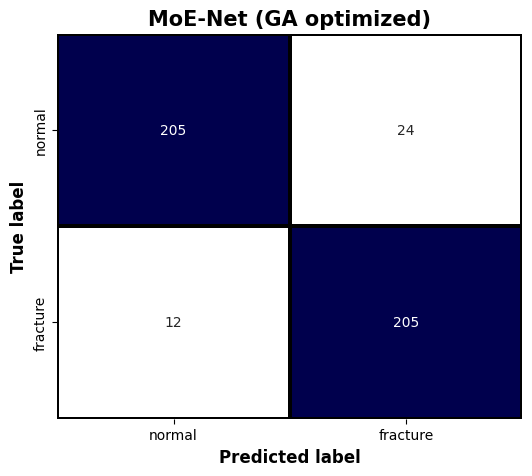

In [ ]:
confusion_matrix_(y_test, y_pred, name="MoE-Net (GA optimized)")

AUC: 0.9199484836898557



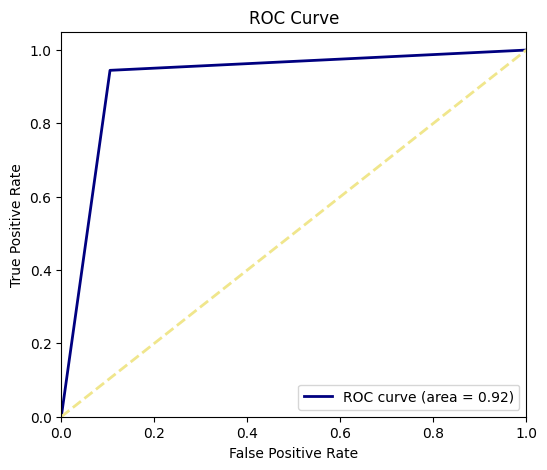

In [ ]:
roc_auc_score_(y_test, y_pred)

In [ ]:
ga_model.save('/content/drive/MyDrive/Models/ga_model.keras')

In [ ]:
with open('/content/drive/MyDrive/Models/ga_hist.pkl', 'wb') as file:
        pickle.dump(ga_hist.history, file)

## Average time per batch

In [13]:
import time
from tqdm import tqdm

def measure_inference_time_generator(model, test_generator, num_batches=None):
    times = []
    n_images = 0

    total_batches = num_batches or len(test_generator)

    for i, (x_batch, _) in enumerate(tqdm(test_generator, total=total_batches)):
        if i >= total_batches:
            break

        start = time.perf_counter()
        _ = model.predict(x_batch, verbose=0)
        end = time.perf_counter()

        times.append(end - start)
        n_images += len(x_batch)

    mean_time = np.mean(times)
    std_time = np.std(times)
    avg_per_image = mean_time / test_generator.batch_size

    print(f"Average time per batch: {mean_time:.4f} seconds ± {std_time:.4f}")
    print(f"Average time per image: {avg_per_image:.4f} seconds")
    print(f"Total number of tested images: {n_images}")


    return mean_time, std_time, avg_per_image


In [ ]:
mean_batch_time, std_batch_time, avg_per_image = measure_inference_time_generator(
    model=ga_model,
    test_generator=test_generator,
    num_batches=None
)


In [ ]:
mean_batch_time, std_batch_time, avg_per_image = measure_inference_time_generator(
    model=expert1,
    test_generator=test_generator,
    num_batches=None
)

In [ ]:
mean_batch_time, std_batch_time, avg_per_image = measure_inference_time_generator(
    model=expert2,
    test_generator=test_generator,
    num_batches=None
)


In [ ]:
mean_batch_time, std_batch_time, avg_per_image = measure_inference_time_generator(
    model=expert3,
    test_generator=test_generator,
    num_batches=None
)


---

In [ ]:
with open('/content/drive/MyDrive/Models/ga_hist.pkl', 'rb') as file:
    ga_hist = pickle.load(file)
with open('/content/drive/MyDrive/Models/final_hist.pkl', 'rb') as file:
    final_hist = pickle.load(file)
with open('/content/drive/MyDrive/Models/Xception_N19_history.pkl', 'rb') as file:
    expert1_hist = pickle.load(file)
with open('/content/drive/MyDrive/Models/DenseNet121_F24_history.pkl', 'rb') as file:
    expert2_hist = pickle.load(file)
with open('/content/drive/MyDrive/Models/InceptionResNetV2_F25_N32_history.pkl', 'rb') as file:
    expert3_hist = pickle.load(file)

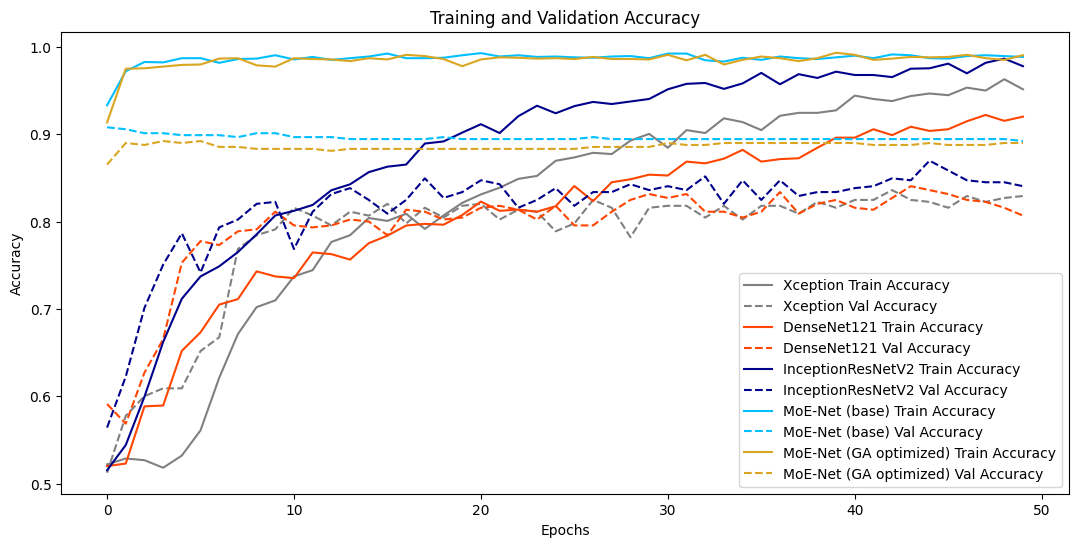

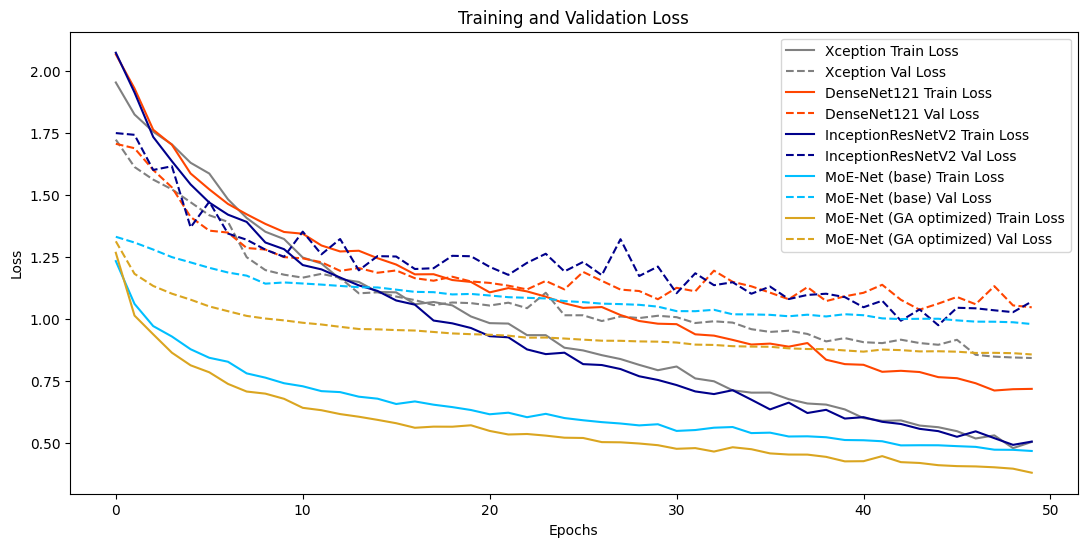

In [ ]:
histories = [expert1_hist, expert2_hist, expert3_hist, final_hist, ga_hist]
colors = ['grey', 'orangered', 'darkblue', 'deepskyblue','goldenrod']
models = ['Xception', 'DenseNet121', 'InceptionResNetV2', 'MoE-Net (base)', 'MoE-Net (GA optimized)']

EPOCHS = 50

plt.figure(figsize=(13, 6))
for i, hist in enumerate(histories):
    plt.plot(hist['accuracy'][:EPOCHS], color=colors[i], linestyle='-', label=f'{models[i]} Train Accuracy')
    plt.plot(hist['val_accuracy'][:EPOCHS], color=colors[i], linestyle='--', label=f'{models[i]} Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6))
for i, hist in enumerate(histories):
    plt.plot(hist['loss'][:EPOCHS], color=colors[i], linestyle='-', label=f'{models[i]} Train Loss')
    plt.plot(hist['val_loss'][:EPOCHS], color=colors[i], linestyle='--', label=f'{models[i]} Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## *P-Value*

In [17]:
def compare_models_pvalue(model1, model2, test_generator, model1_name="Model 1", model2_name="Model 2"):
    test_generator.reset()

    x_test = []
    y_test = []
    for x_batch, y_batch in test_generator:
        x_test.append(x_batch)
        y_test.append(y_batch)

    x_test = np.concatenate(x_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    if y_test.ndim == 1:
        true_labels = y_test.astype(int)
    elif y_test.shape[1] == 1:
        true_labels = y_test.flatten().astype(int)
    else:
        true_labels = np.argmax(y_test, axis=1)

    pred1_prob = model1.predict(x_test, verbose=0)
    pred1 = np.argmax(pred1_prob, axis=1)

    pred2_prob = model2.predict(x_test, verbose=0)
    pred2 = np.argmax(pred2_prob, axis=1)

    acc1 = accuracy_score(true_labels, pred1)
    acc2 = accuracy_score(true_labels, pred2)

    correct1 = (pred1 == true_labels).astype(int)
    correct2 = (pred2 == true_labels).astype(int)

    t_stat, p_value = ttest_rel(correct1, correct2)

    print("\n" + "="*60)
    print(f"Statistical Comparison: {model1_name} vs {model2_name}")
    print("="*60)
    print(f"Number of test images       : {len(true_labels)}")
    print(f"Accuracy ({model1_name})     : {acc1:.4f} ({acc1*100:.2f}%)")
    print(f"Accuracy ({model2_name})     : {acc2:.4f} ({acc2*100:.2f}%)")
    print(f"t-statistic                 : {t_stat:.4f}")
    print(f"p-value                     : {p_value:.2e}")

    if p_value < 0.001:
        significance = "highly significant (p < 0.001)"
    elif p_value < 0.05:
        significance = "statistically significant (p < 0.05)"
    else:
        significance = "not statistically significant (p ≥ 0.05)"

    print(f"Result                      : Difference is {significance}")
    if acc1 > acc2 and p_value < 0.05:
        print(f" → {model1_name} significantly outperforms {model2_name}")
    print("="*60)

In [ ]:
compare_models_pvalue(
    model1=ga_model,
    model2=expert2,
    test_generator=test_generator,
    model1_name="MoE-Net (GA-optimized)",
    model2_name="Expert 1 (DenseNet121)"
)